In [2]:
import sys
sys.path.append('..')

In [3]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [5]:
from DomainPrediction.utils import helper
from DomainPrediction.eval import metrics
from DomainPrediction.al import top_model as topmodel
from DomainPrediction.al.embeddings import one_hot_encode

In [ ]:
from DomainPrediction.esm.esm2 import ESM2
from DomainPrediction.al.confit import ESM2ConFit

In [6]:
sys.path.append('../../esm')
from DomainPrediction.esm.esm3 import ESM3LM
from DomainPrediction.esm.esmc import ESMCLM
from DomainPrediction.al.confit import ESMCConFit

#### Load Data

In [7]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/GB1'

In [8]:
file = os.path.join(data_path, 'dataset_gb1.csv')
df = pd.read_csv(file)

In [9]:
df.head()

,seq,fitness_raw,split_id,n_mut,fitness_log
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,2,0,0.000000
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,2,1,0.371564
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,2,1,0.524729
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,2,1,0.157004
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,2,1,0.875469


In [10]:
results_file = os.path.join(data_path, 'results_GB1_zeroshot.csv')

In [11]:
if os.path.isfile(results_file):
    df_results = pd.read_csv(results_file)
else:
    df_results = df.copy()

In [12]:
df_results.head()

,seq,fitness_raw,split_id,n_mut,fitness_log,pred_ESM650M_masked_marginal,pred_ESM3_masked_marginal,pred_ESMC300M_masked_marginal,pred_ESMC600M_masked_marginal,pred_ESMC300M_confit
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,2,0,0.000000,0.000000,0.000000,0.000,0.000000,0.0000
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,2,1,0.371564,-0.079431,0.328125,0.250,0.492188,-0.0625
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,2,1,0.524729,0.555604,0.476562,0.750,0.867188,-0.1875
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,2,1,0.157004,-1.379841,-1.953125,-1.375,-1.375000,-1.1250
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,2,1,0.875469,0.137812,0.481445,-0.125,-0.312500,1.1250


In [13]:
df_results.columns[df_results.columns.str.contains('pred')]

Index(['pred_ESM650M_masked_marginal', 'pred_ESM3_masked_marginal',
       'pred_ESMC300M_masked_marginal', 'pred_ESMC600M_masked_marginal',
       'pred_ESMC300M_confit'],
      dtype='object')

In [14]:
len(df_results.columns[df_results.columns.str.contains('pred')])

5

In [15]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    val_mask = df['split_id'] == 1
    test_mask = df['split_id'] == 0

    return train_mask, val_mask, test_mask

#### OHE

In [ ]:
embeddings = one_hot_encode(df['seq'])

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

# y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_OHE_ridge'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_ridge'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_ridge'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_OHE_RF'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_RF'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_RF'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [5300, 512, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 10,
        'early_stopping': True,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_OHE_MLP'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_OHE_MLP'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_OHE_MLP'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3 and ESMC Embeddings

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
# embeddings = esm2.get_embeddings_flatten(df['seq'])
# embeddings = esm3.get_embeddings_flatten(df['seq'])
embeddings = esmc.get_embeddings_flatten(df['seq'])

In [ ]:
embeddings.shape

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)

X_train = embeddings[train_mask]
X_val = embeddings[val_mask]
X_test = embeddings[test_mask]

# y_train = df.loc[train_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_val = df.loc[val_mask, 'fitness_raw'].to_numpy().astype(np.float32)
# y_test = df.loc[test_mask, 'fitness_raw'].to_numpy().astype(np.float32)

y_train = df.loc[train_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)
y_test = df.loc[test_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [ ]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_ESMC600M_concat_ridge'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_concat_ridge'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_concat_ridge'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
surrogate = topmodel.RFSurrogate()
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
y_pred = surrogate.predict(embeddings)
assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
df_results['pred_ESM650M_concat_RF'] = y_pred

mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESM650M_concat_RF'])
corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESM650M_concat_RF'])
s_corr = round(corr.statistic, 2)
print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

In [ ]:
print(f'input layer shape: {X_train.shape[1]}')

In [ ]:
config={'layers': [265, 128, 1], 
        'epoch': 100, 
        'batch_size': 16,
        'patience': 20,
        'early_stopping': True,
        'lr': 1e-3,
        'print_every_n_epoch': 10,
        'debug': True}
surrogate = topmodel.MLPSurrogate(config=config)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

In [ ]:
y_train_pred = surrogate.predict(X_train)
y_val_pred = surrogate.predict(X_val)
y_test_pred = surrogate.predict(X_test)
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.5)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.5)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.5)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# y_pred = surrogate.predict(embeddings)
# assert y_pred.shape[0] == embeddings.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_feat_mean_MLP'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_feat_mean_MLP'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_feat_mean_MLP'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ESM2, ESM3, ESMC - ZeroShot Margials

In [ ]:
# esm2 = ESM2(model_path='/data/users/kgeorge/workspace/esm2/checkpoints/esm2_t33_650M_UR50D.pt', device='gpu')
# esm3 = ESM3LM(device='gpu')
# esmc = ESMCLM(name='esmc_300m', device='gpu')
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'GB1_WT.fasta'), mode='str')[0]

In [ ]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    # score, n_muts = esm2.get_masked_marginal(mt_sequence, wt_sequence)
    # score, n_muts = esm3.get_masked_marginal(mt_sequence, wt_sequence)
    score, n_muts = esmc.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)

In [ ]:
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,3), layout='constrained')

ax.plot(y, y_pred, '.', alpha=0.5)
mse = mean_squared_error(y, y_pred)
corr = stats.spearmanr(y, y_pred)
s_corr = round(corr.statistic, 2)
ax.set_title(f'Full Dataset \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

train_mask, val_mask, test_mask = get_split_mask(df)

for i, (dset, _mask) in enumerate(zip(['train', 'val', 'test'], 
                                      [train_mask, val_mask, test_mask])):
    ax[i].plot(y[_mask], y_pred[_mask], '.', alpha=0.5)
    mse = mean_squared_error(y[_mask], y_pred[_mask])
    corr = stats.spearmanr(y[_mask], y_pred[_mask])
    s_corr = round(corr.statistic, 2)
    ax[i].set_title(f'{dset} \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

In [ ]:
# assert y_pred.shape[0] == df_results.shape[0]
# df_results['pred_ESMC600M_masked_marginal'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC600M_masked_marginal'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC600M_masked_marginal'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### ConFit - Contrastive Fitness Learning

In [ ]:
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
df_train = df[train_mask]
df_val = df[val_mask]
df_test = df[test_mask]

In [ ]:
config={'epoch': 10, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
surrogate = ESMCConFit(name='esmc_300m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

In [ ]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'GB1_WT.fasta'), mode='str')[0]

In [ ]:
surrogate.sanity_check(df_train, wt_sequence)

In [ ]:
surrogate.trainmodel(df_train, wt_sequence, df_val)

In [ ]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)
y = df['fitness_log'].to_numpy().astype(np.float32)

In [ ]:
y_train_pred, y_train = y_pred[train_mask], y[train_mask]
y_val_pred, y_val = y_pred[val_mask], y[val_mask]
y_test_pred, y_test = y_pred[test_mask], y[test_mask]

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.8)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
omit_mask = df['fitness_raw'] != 0
y_train_pred, y_train = y_pred[train_mask & omit_mask], y[train_mask & omit_mask]
y_val_pred, y_val = y_pred[val_mask & omit_mask], y[val_mask & omit_mask]
y_test_pred, y_test = y_pred[test_mask & omit_mask], y[test_mask & omit_mask]

fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')
ax[0].plot(y_train, y_train_pred, '.', alpha=0.8)
ax[1].plot(y_val, y_val_pred, '.', alpha=0.8)
ax[2].plot(y_test, y_test_pred, '.', alpha=0.8)

mse = mean_squared_error(y_train, y_train_pred)
corr = stats.spearmanr(y_train, y_train_pred)
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_val, y_val_pred)
corr = stats.spearmanr(y_val, y_val_pred)
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y_test, y_test_pred)
corr = stats.spearmanr(y_test, y_test_pred)
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [ ]:
# assert y_pred.shape[0] == df_results.shape[0]
# df_results['pred_ESMC300M_confit'] = y_pred

# mse = mean_squared_error(df_results['fitness_log'], df_results['pred_ESMC300M_confit'])
# corr = stats.spearmanr(df_results['fitness_log'], df_results['pred_ESMC300M_confit'])
# s_corr = round(corr.statistic, 2)
# print(f'mse : {str(round(mse, 2))} || spearman correlation = {s_corr}')

# df_results.to_csv(results_file, index=False)

In [ ]:
df_results.columns[df_results.columns.str.contains('pred')]

#### Simulation Low-N setting

In [32]:
n_samples = 53

In [33]:
omit_mask = df['fitness_raw'] != 0
train_mask, val_mask, test_mask = get_split_mask(df, omit_zero=False)
print(f'n samples: train {train_mask.sum()} val {val_mask.sum()} test {test_mask.sum()}')

random_indices = df[train_mask & omit_mask].sample(n=n_samples, random_state=0).index
selected_mask = df.index.isin(random_indices)

train_mask_selected = selected_mask
train_mask_rest = train_mask & ~selected_mask
print(f'n samples: train selected {train_mask_selected.sum()} train rest {train_mask_rest.sum()}')

df_train = df[train_mask_selected]
df_train_rest = df[train_mask_rest]
df_val = df[val_mask]
df_test = df[test_mask]

n samples: train 2691 val 299 test 5743
n samples: train selected 53 train rest 2638


In [40]:
df_train.shape[0] + df_train_rest.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0]

True

In [ ]:
# Index([1287,  326, 2442,  945, 1296, 2046, 2016,  517,  468, 2261, 1932, 1518,
#         159,  947, 1178,  229, 1939, 2538, 2256, 1555, 1182,  137, 2131,  716,
#        1231,  415, 1332, 1157,  608, 1919, 1458, 2324,  994,  150,  368, 1772,
#         196,   33, 1786,  545, 2018, 1666,  775, 2433,  620, 1151,  457,  503,
#        1766,  295,  896, 2091,  927],
#       dtype='int64')

In [35]:
random_indices

Index([1287,  326, 2442,  945, 1296, 2046, 2016,  517,  468, 2261, 1932, 1518,
        159,  947, 1178,  229, 1939, 2538, 2256, 1555, 1182,  137, 2131,  716,
       1231,  415, 1332, 1157,  608, 1919, 1458, 2324,  994,  150,  368, 1772,
        196,   33, 1786,  545, 2018, 1666,  775, 2433,  620, 1151,  457,  503,
       1766,  295,  896, 2091,  927],
      dtype='int64')

In [24]:
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [25]:
embeddings = esmc.get_embeddings_flatten(df['seq'])

100%|██████████| 8733/8733 [04:48<00:00, 30.26it/s]


In [60]:
X_train = embeddings[train_mask_selected]
X_val = embeddings[val_mask]

y_train = df.loc[train_mask_selected, 'fitness_log'].to_numpy().astype(np.float32)
y_val = df.loc[val_mask, 'fitness_log'].to_numpy().astype(np.float32)

In [61]:
surrogate = topmodel.RidgeSurrogate(alpha=1.0)
surrogate.trainmodel(X=X_train, y=y_train, val=(X_val, y_val))

train: mse = 0.18872974812984467, spearman correlation = 0.8723863592372737
val: mse = 17.31854820251465, spearman correlation = 0.5863776760021012


In [62]:
y_pred = surrogate.predict(embeddings)
y = df['fitness_log'].to_numpy().astype(np.float32)

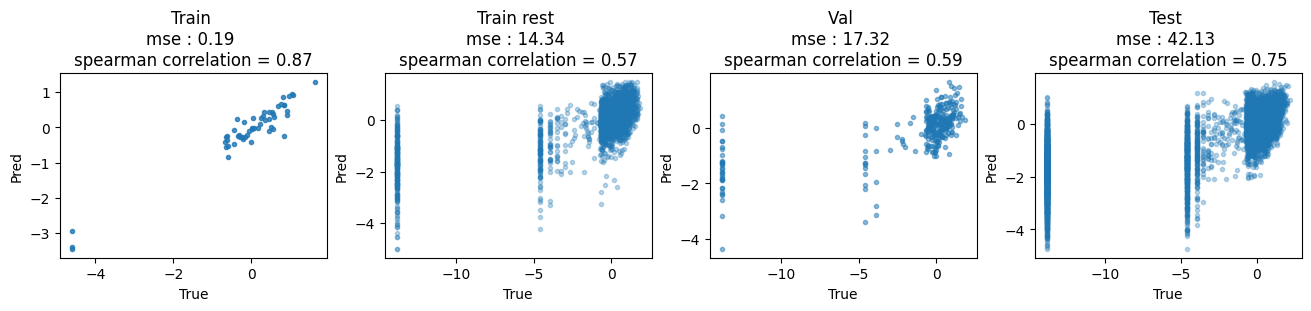

In [63]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected], y_pred[train_mask_selected], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest], y_pred[train_mask_rest], '.', alpha=0.3)
ax[2].plot(y[val_mask], y_pred[val_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask], y_pred[test_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected], y_pred[train_mask_selected])
corr = stats.spearmanr(y[train_mask_selected], y_pred[train_mask_selected])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[train_mask_rest], y_pred[train_mask_rest])
corr = stats.spearmanr(y[train_mask_rest], y_pred[train_mask_rest])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask], y_pred[val_mask])
corr = stats.spearmanr(y[val_mask], y_pred[val_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask], y_pred[test_mask])
corr = stats.spearmanr(y[test_mask], y_pred[test_mask])
s_corr = round(corr.statistic, 2)
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

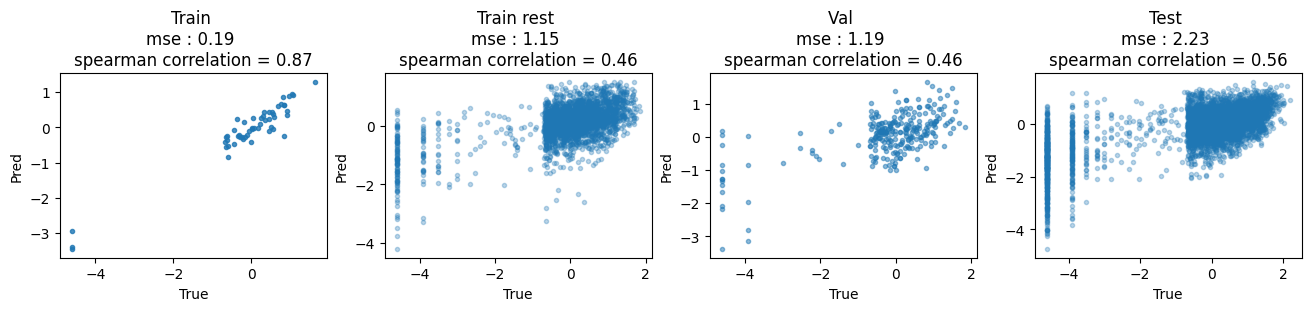

In [64]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask], '.', alpha=0.3)
ax[2].plot(y[val_mask & omit_mask], y_pred[val_mask & omit_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask & omit_mask], y_pred[test_mask & omit_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
corr = stats.spearmanr(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask])
corr = stats.spearmanr(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
corr = stats.spearmanr(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
corr = stats.spearmanr(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
s_corr = round(corr.statistic, 2)
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

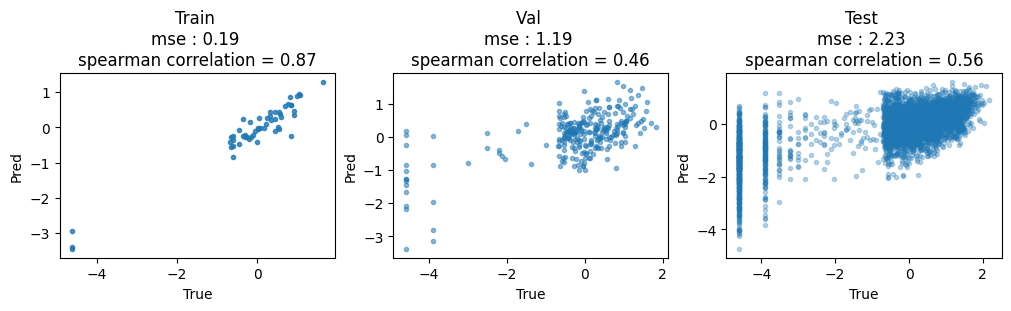

In [65]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

ax[0].plot(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask], '.', alpha=0.8)
ax[1].plot(y[val_mask & omit_mask], y_pred[val_mask & omit_mask], '.', alpha=0.5)
ax[2].plot(y[test_mask & omit_mask], y_pred[test_mask & omit_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
corr = stats.spearmanr(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
corr = stats.spearmanr(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
corr = stats.spearmanr(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

In [47]:
config={'epoch': 30, 
        'batch_size': 8,
        'lambda': 0.1,
        'accumulate_batch_size': 32,
        'patience': 20,
        'early_stopping': False,
        'lr': 5e-4,
        'print_every_n_epoch': 1,
        'device': 'gpu'}
surrogate = ESMCConFit(name='esmc_600m', config=config)
surrogate.print_trainable_parameters(surrogate.model)

trainable params: 746496 || all params: 575700544 || trainable%: 0.13


In [48]:
wt_sequence = helper.read_fasta(os.path.join(data_path, 'GB1_WT.fasta'), mode='str')[0]

In [49]:
surrogate.sanity_check(df_train, wt_sequence)

In [50]:
surrogate.trainmodel(df_train, wt_sequence, df_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-14 23:56:55.046280: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 23:56:55.893681: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 23:56:56.497565: E externa

Epoch: 0: train loss: 30.983760152544296 val loss: 29.502723844427813
Epoch: 1: train loss: 34.127462932041716 val loss: 29.391615001778852
Epoch: 2: train loss: 30.578126634870255 val loss: 29.2652143930134
Epoch: 3: train loss: 30.959615434919083 val loss: 29.095969112295855
Epoch: 4: train loss: 28.800477164132253 val loss: 28.935242991698416
Epoch: 5: train loss: 27.254279000418528 val loss: 28.942260052028455
Epoch: 6: train loss: 29.044253758021764 val loss: 28.598811099403783
Epoch: 7: train loss: 29.96059594835554 val loss: 28.67858274359452
Epoch: 8: train loss: 26.294750486101425 val loss: 28.19048523902893
Epoch: 9: train loss: 27.377878870282853 val loss: 27.953000821565325
Epoch: 10: train loss: 25.436172076633998 val loss: 27.664093431673553
Epoch: 11: train loss: 24.985052926199778 val loss: 27.082174690146196
Epoch: 12: train loss: 24.00716645377023 val loss: 26.516829239694697
Epoch: 13: train loss: 24.021596908569336 val loss: 25.986513100172346
Epoch: 14: train loss:

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch: 30: train loss: 16.46824734551566 val loss: 22.267097686466418


In [51]:
## masked marginals
y_pred = []
for i, row in tqdm(df.iterrows()):
    mt_sequence = row['seq']
    score, n_muts = surrogate.get_masked_marginal(mt_sequence, wt_sequence)

    assert n_muts == row['n_mut']

    y_pred.append(score)

y_pred = np.array(y_pred)
y = df['fitness_log'].to_numpy().astype(np.float32)

8733it [05:27, 26.66it/s]


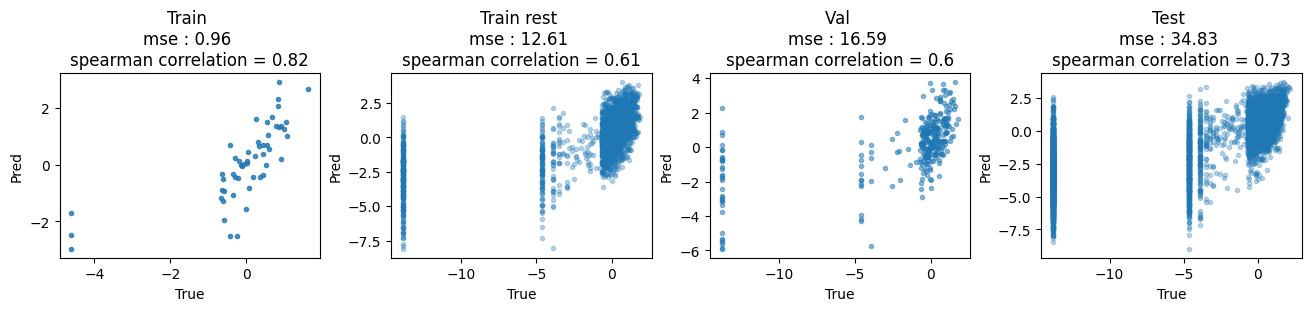

In [52]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected], y_pred[train_mask_selected], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest], y_pred[train_mask_rest], '.', alpha=0.3)
ax[2].plot(y[val_mask], y_pred[val_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask], y_pred[test_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected], y_pred[train_mask_selected])
corr = stats.spearmanr(y[train_mask_selected], y_pred[train_mask_selected])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[train_mask_rest], y_pred[train_mask_rest])
corr = stats.spearmanr(y[train_mask_rest], y_pred[train_mask_rest])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask], y_pred[val_mask])
corr = stats.spearmanr(y[val_mask], y_pred[val_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask], y_pred[test_mask])
corr = stats.spearmanr(y[test_mask], y_pred[test_mask])
s_corr = round(corr.statistic, 2)
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

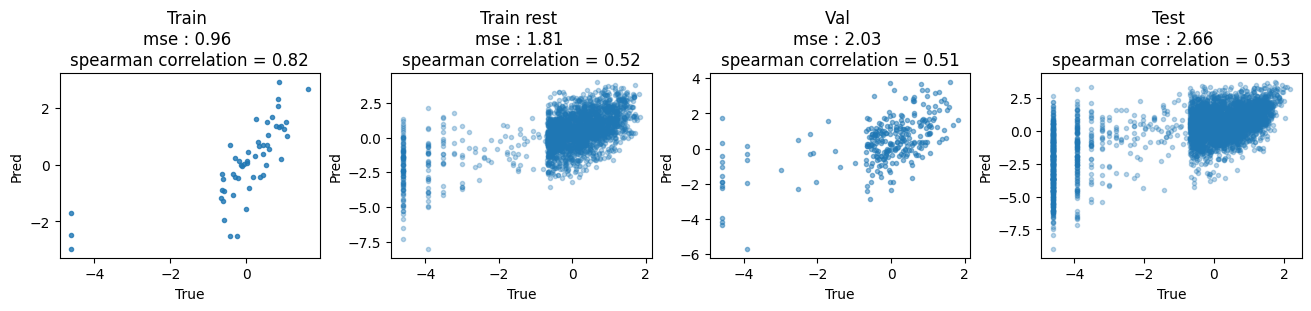

In [53]:
fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

ax[0].plot(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask], '.', alpha=0.8)
ax[1].plot(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask], '.', alpha=0.3)
ax[2].plot(y[val_mask & omit_mask], y_pred[val_mask & omit_mask], '.', alpha=0.5)
ax[3].plot(y[test_mask & omit_mask], y_pred[test_mask & omit_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
corr = stats.spearmanr(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask])
corr = stats.spearmanr(y[train_mask_rest & omit_mask], y_pred[train_mask_rest & omit_mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Train rest \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
corr = stats.spearmanr(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
corr = stats.spearmanr(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
s_corr = round(corr.statistic, 2)
ax[3].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(4):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()

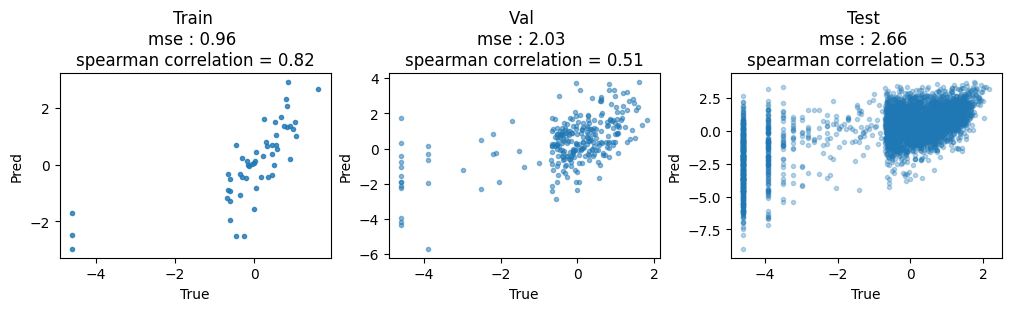

In [55]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='constrained')

ax[0].plot(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask], '.', alpha=0.8)
ax[1].plot(y[val_mask & omit_mask], y_pred[val_mask & omit_mask], '.', alpha=0.5)
ax[2].plot(y[test_mask & omit_mask], y_pred[test_mask & omit_mask], '.', alpha=0.3)

mse = mean_squared_error(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
corr = stats.spearmanr(y[train_mask_selected & omit_mask], y_pred[train_mask_selected & omit_mask])
s_corr = round(corr.statistic, 2)
ax[0].set_title(f'Train \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
corr = stats.spearmanr(y[val_mask & omit_mask], y_pred[val_mask & omit_mask])
s_corr = round(corr.statistic, 2)
ax[1].set_title(f'Val \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

mse = mean_squared_error(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
corr = stats.spearmanr(y[test_mask & omit_mask], y_pred[test_mask & omit_mask])
s_corr = round(corr.statistic, 2)
ax[2].set_title(f'Test \nmse : {str(round(mse, 2))} \nspearman correlation = {s_corr}')

for i in range(3):
    ax[i].set_xlabel('True')
    ax[i].set_ylabel('Pred')

plt.show()